<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Darts_MotorVehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Darts**
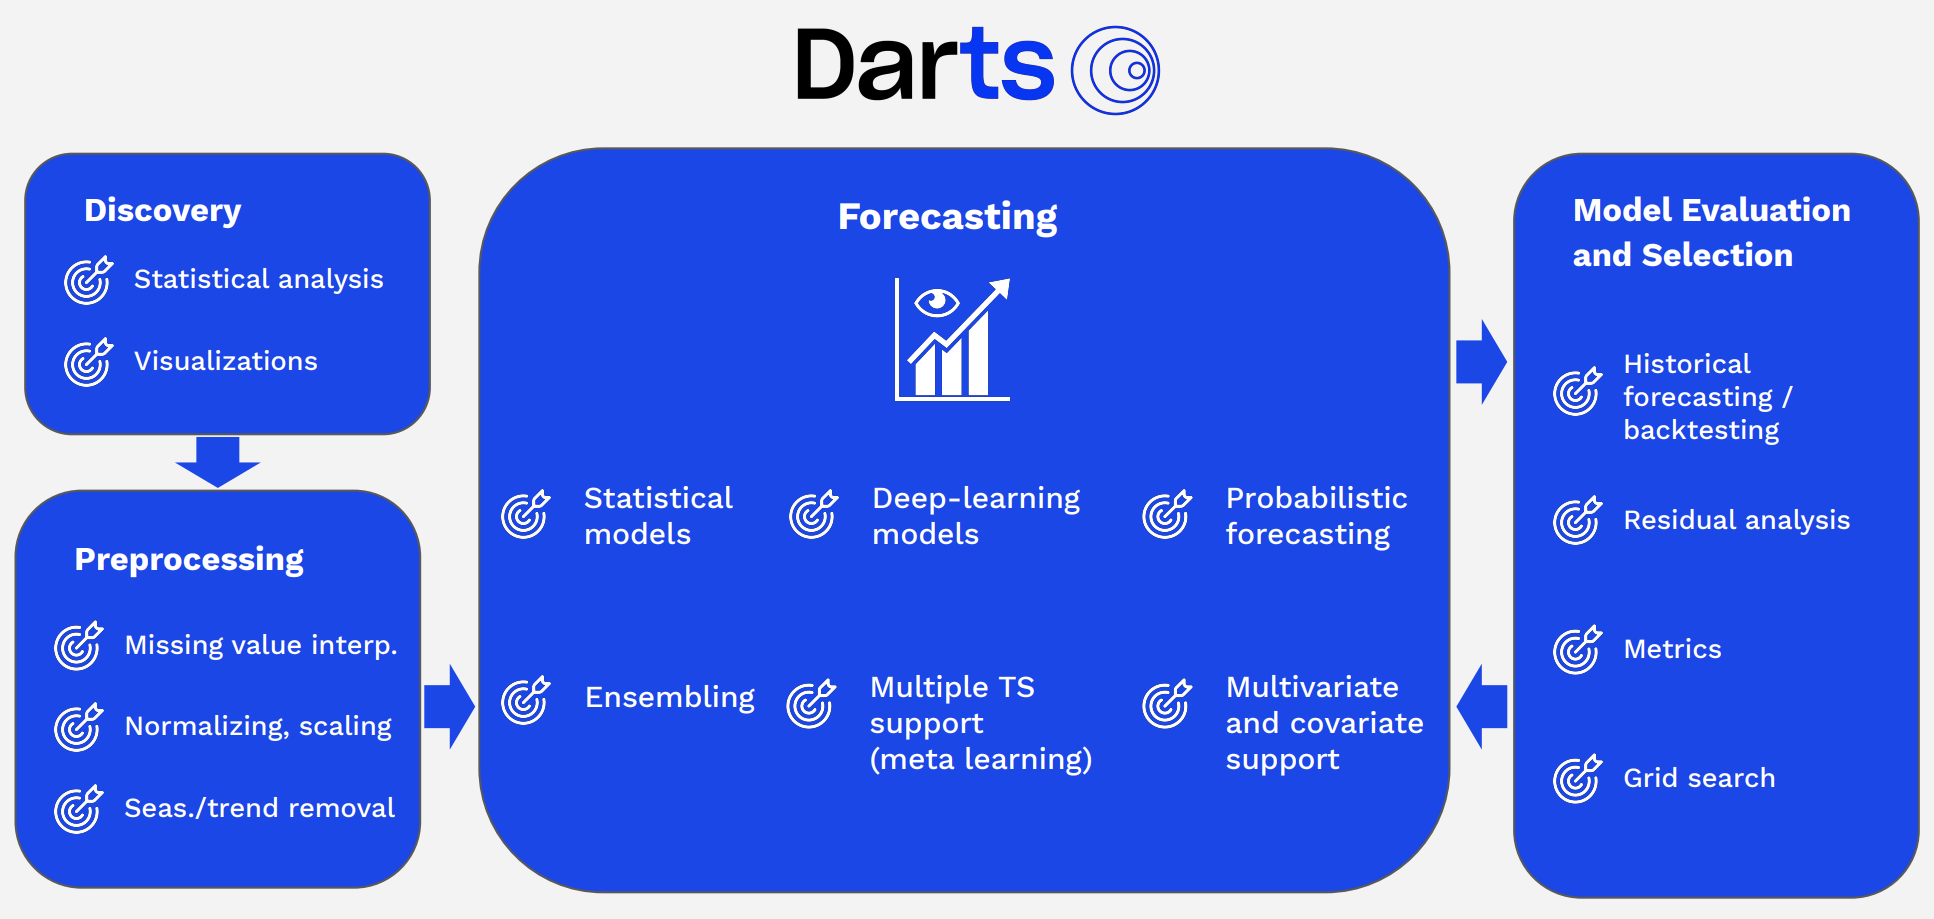

In [1]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.9

**Import Libraries**

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (7,5)

import torch
from darts.metrics import mape, smape, mae, rmse
from darts import TimeSeries

from darts.utils.callbacks import TFMProgressBar

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

**Dataset**

https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [6]:
#read csv file into dataframe
data_url = 'https://raw.githubusercontent.com/myconcordia/A2I2/main/nyc_collision_factors.csv'
df = pd.read_csv(data_url)
df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           7303 non-null   object 
 1   TIME                           7303 non-null   object 
 2   BOROUGH                        6920 non-null   object 
 3   ZIP CODE                       6919 non-null   float64
 4   LATITUDE                       7303 non-null   float64
 5   LONGITUDE                      7303 non-null   float64
 6   LOCATION                       7303 non-null   object 
 7   ON STREET NAME                 6238 non-null   object 
 8   CROSS STREET NAME              6166 non-null   object 
 9   OFF STREET NAME                761 non-null    object 
 10  NUMBER OF PERSONS INJURED      7303 non-null   int64  
 11  NUMBER OF PERSONS KILLED       7303 non-null   int64  
 12  NUMBER OF PEDESTRIANS INJURED  7303 non-null   i

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,11/10/2016,16:11:00,BROOKLYN,11208.0,40.662514,-73.872007,"(40.6625139, -73.8720068)",WORTMAN AVENUE,MONTAUK AVENUE,NaN,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,TAXI,PASSENGER VEHICLE,NaN,NaN,NaN
1,11/10/2016,05:11:00,MANHATTAN,10013.0,40.721323,-74.008344,"(40.7213228, -74.0083444)",HUBERT STREET,HUDSON STREET,NaN,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2,04/16/2016,09:15:00,BROOKLYN,11201.0,40.687999,-73.997563,"(40.6879989, -73.9975625)",HENRY STREET,WARREN STREET,NaN,...,Lost Consciousness,Lost Consciousness,NaN,NaN,NaN,PASSENGER VEHICLE,VAN,NaN,NaN,NaN
3,04/15/2016,10:20:00,QUEENS,11375.0,40.719228,-73.854542,"(40.7192276, -73.8545422)",NaN,NaN,67-64 FLEET STREET,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN
4,04/15/2016,10:35:00,BROOKLYN,11210.0,40.632147,-73.952731,"(40.6321467, -73.9527315)",BEDFORD AVENUE,CAMPUS ROAD,NaN,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


**Combine DATE and TIME into a new column Date**. Then, drop both and move the last column to the first position.

In [7]:
df['Date'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
df = df.drop(columns=['DATE', 'TIME'])
cols = df.columns.tolist()
df = df[cols[-1:] + cols[:-1]]
df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           7303 non-null   datetime64[ns]
 1   BOROUGH                        6920 non-null   object        
 2   ZIP CODE                       6919 non-null   float64       
 3   LATITUDE                       7303 non-null   float64       
 4   LONGITUDE                      7303 non-null   float64       
 5   LOCATION                       7303 non-null   object        
 6   ON STREET NAME                 6238 non-null   object        
 7   CROSS STREET NAME              6166 non-null   object        
 8   OFF STREET NAME                761 non-null    object        
 9   NUMBER OF PERSONS INJURED      7303 non-null   int64         
 10  NUMBER OF PERSONS KILLED       7303 non-null   int64         
 11  NUMBER OF PEDESTR

,Date,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2016-11-10 16:11:00,BROOKLYN,11208.0,40.662514,-73.872007,"(40.6625139, -73.8720068)",WORTMAN AVENUE,MONTAUK AVENUE,NaN,0,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,TAXI,PASSENGER VEHICLE,NaN,NaN,NaN
1,2016-11-10 05:11:00,MANHATTAN,10013.0,40.721323,-74.008344,"(40.7213228, -74.0083444)",HUBERT STREET,HUDSON STREET,NaN,1,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2,2016-04-16 09:15:00,BROOKLYN,11201.0,40.687999,-73.997563,"(40.6879989, -73.9975625)",HENRY STREET,WARREN STREET,NaN,0,...,Lost Consciousness,Lost Consciousness,NaN,NaN,NaN,PASSENGER VEHICLE,VAN,NaN,NaN,NaN
3,2016-04-15 10:20:00,QUEENS,11375.0,40.719228,-73.854542,"(40.7192276, -73.8545422)",NaN,NaN,67-64 FLEET STREET,0,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN
4,2016-04-15 10:35:00,BROOKLYN,11210.0,40.632147,-73.952731,"(40.6321467, -73.9527315)",BEDFORD AVENUE,CAMPUS ROAD,NaN,0,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


**Numerical and categorical variables**

In [8]:
num_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)
cat_columns = list(df.select_dtypes(include=['object']).columns)
print('Numerical features:', num_columns)
print('Categorical features:', cat_columns)

Numerical features: ['ZIP CODE', 'LATITUDE', 'LONGITUDE', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLISTS INJURED', 'NUMBER OF CYCLISTS KILLED']
Categorical features: ['BOROUGH', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']


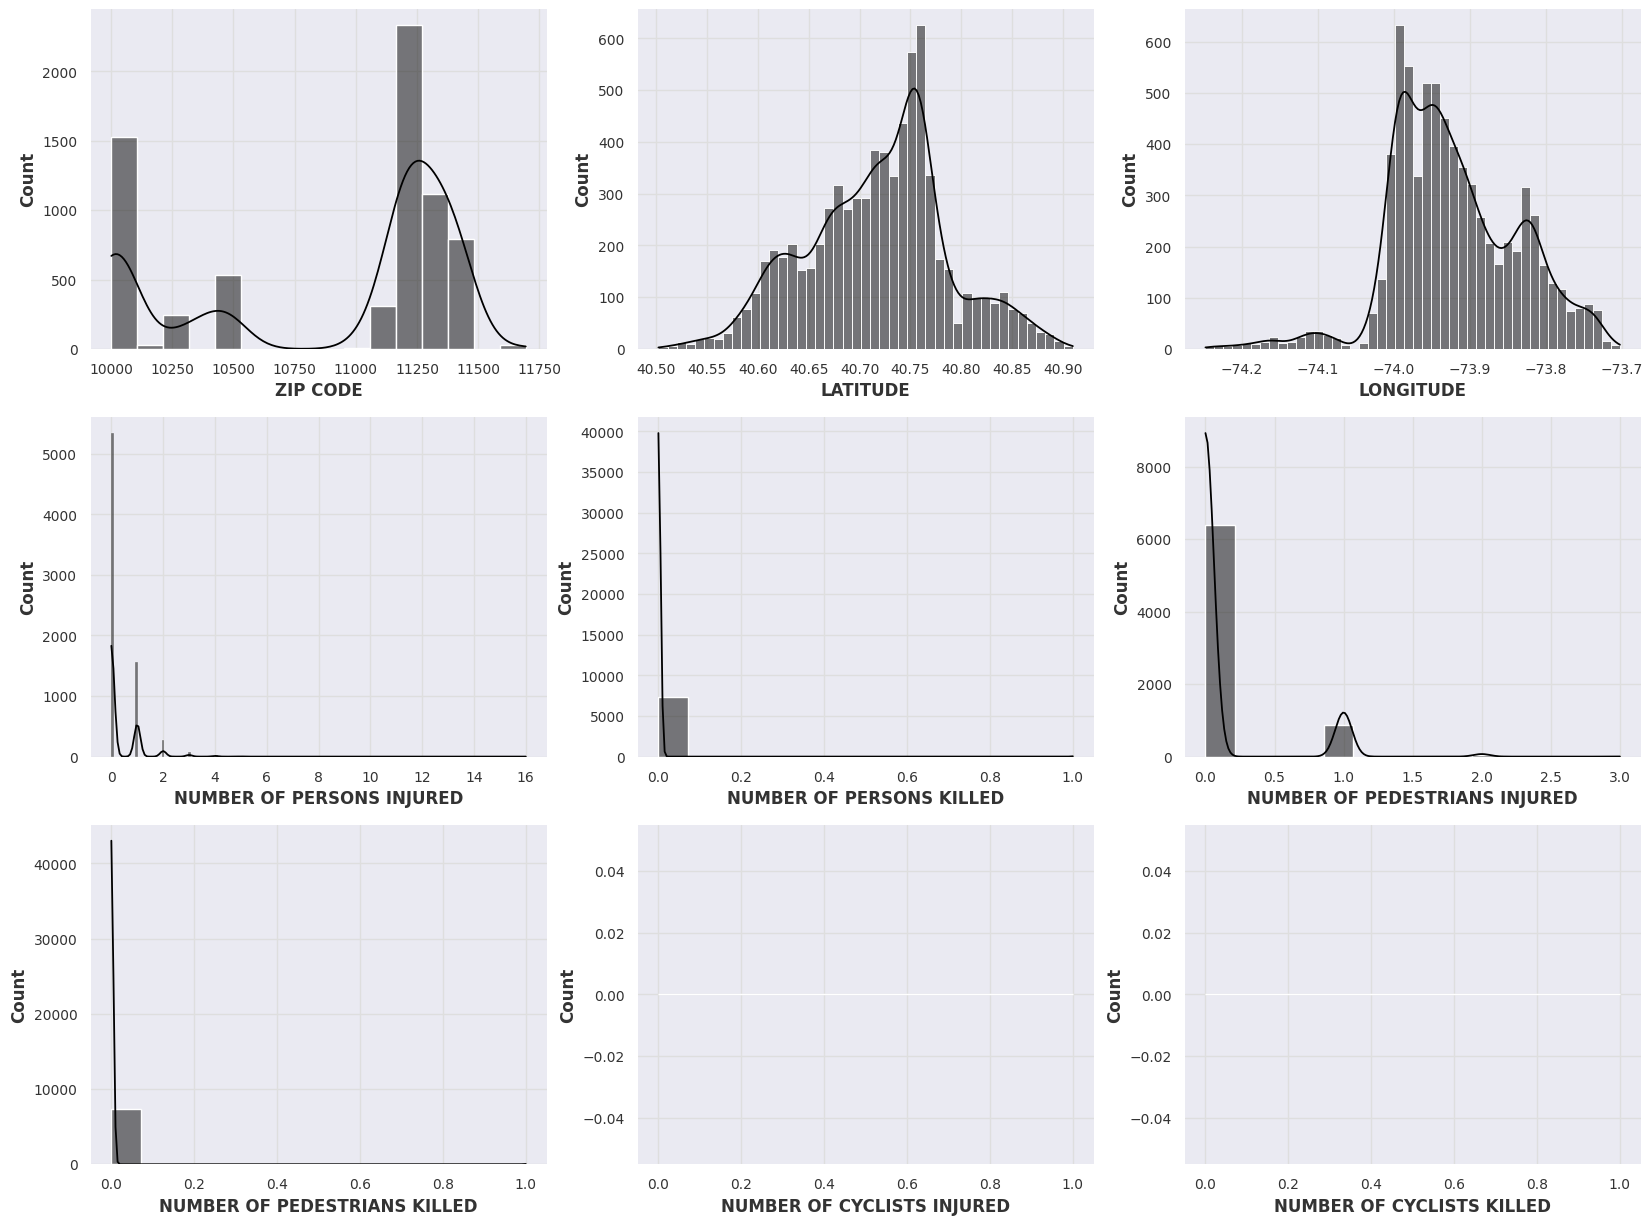

In [6]:
plt.figure(figsize=(20, 15))
for i, num in enumerate(num_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df, x=num, kde=True)

# **Exploratory Data Analysis**

In [7]:
#Install Plotly, an interactive library
!pip install plotly --quiet

In [8]:
import plotly.graph_objects as go

In [ ]:
import plotly.express as px

# Groupping by ON STREET NAME and CROSS STREET NAME
df_summary = df.groupby(['ON STREET NAME', 'CROSS STREET NAME'])['NUMBER OF CYCLISTS INJURED'].sum().reset_index()

# Create a nested pie chart
px.sunburst(df_summary,
            path=['ON STREET NAME', 'CROSS STREET NAME'],
            values='NUMBER OF CYCLISTS INJURED')


**Checking for missing values**

In [11]:
# find the number of missing values in each column
print("Number of missing values in each column is :")
df.isnull().sum()

Number of missing values in each column is :


Date                                0
BOROUGH                           383
ZIP CODE                          384
LATITUDE                            0
LONGITUDE                           0
LOCATION                            0
ON STREET NAME                   1065
CROSS STREET NAME                1137
OFF STREET NAME                  6542
NUMBER OF PERSONS INJURED           0
NUMBER OF PERSONS KILLED            0
NUMBER OF PEDESTRIANS INJURED       0
NUMBER OF PEDESTRIANS KILLED        0
NUMBER OF CYCLISTS INJURED       7303
NUMBER OF CYCLISTS KILLED        7303
CONTRIBUTING FACTOR VEHICLE 1       0
CONTRIBUTING FACTOR VEHICLE 2    1085
CONTRIBUTING FACTOR VEHICLE 3    7000
CONTRIBUTING FACTOR VEHICLE 4    7244
CONTRIBUTING FACTOR VEHICLE 5    7289
VEHICLE TYPE CODE 1                58
VEHICLE TYPE CODE 2              1520
VEHICLE TYPE CODE 3              7019
VEHICLE TYPE CODE 4              7249
VEHICLE TYPE CODE 5              7291
dtype: int64

In [12]:
# Calculate the percentage of missing values for each column
missing_percentages = (df.isnull().sum() / len(df)) * 100

# Create a bar chart
fig = go.Figure(data=[go.Bar(
    x=missing_percentages.index,
    y=missing_percentages.values,
    marker_color='lightsalmon'  # Adjust the color as needed
)])

# Update layout
fig.update_layout(
    title='Percentage of Missing Values in Each Column',
    xaxis_title='Columns',
    yaxis_title='Percentage Missing (%)'
)

# Show the plot
fig.show()

**Analysis of Missing Data by Visualisation**

<Axes: >

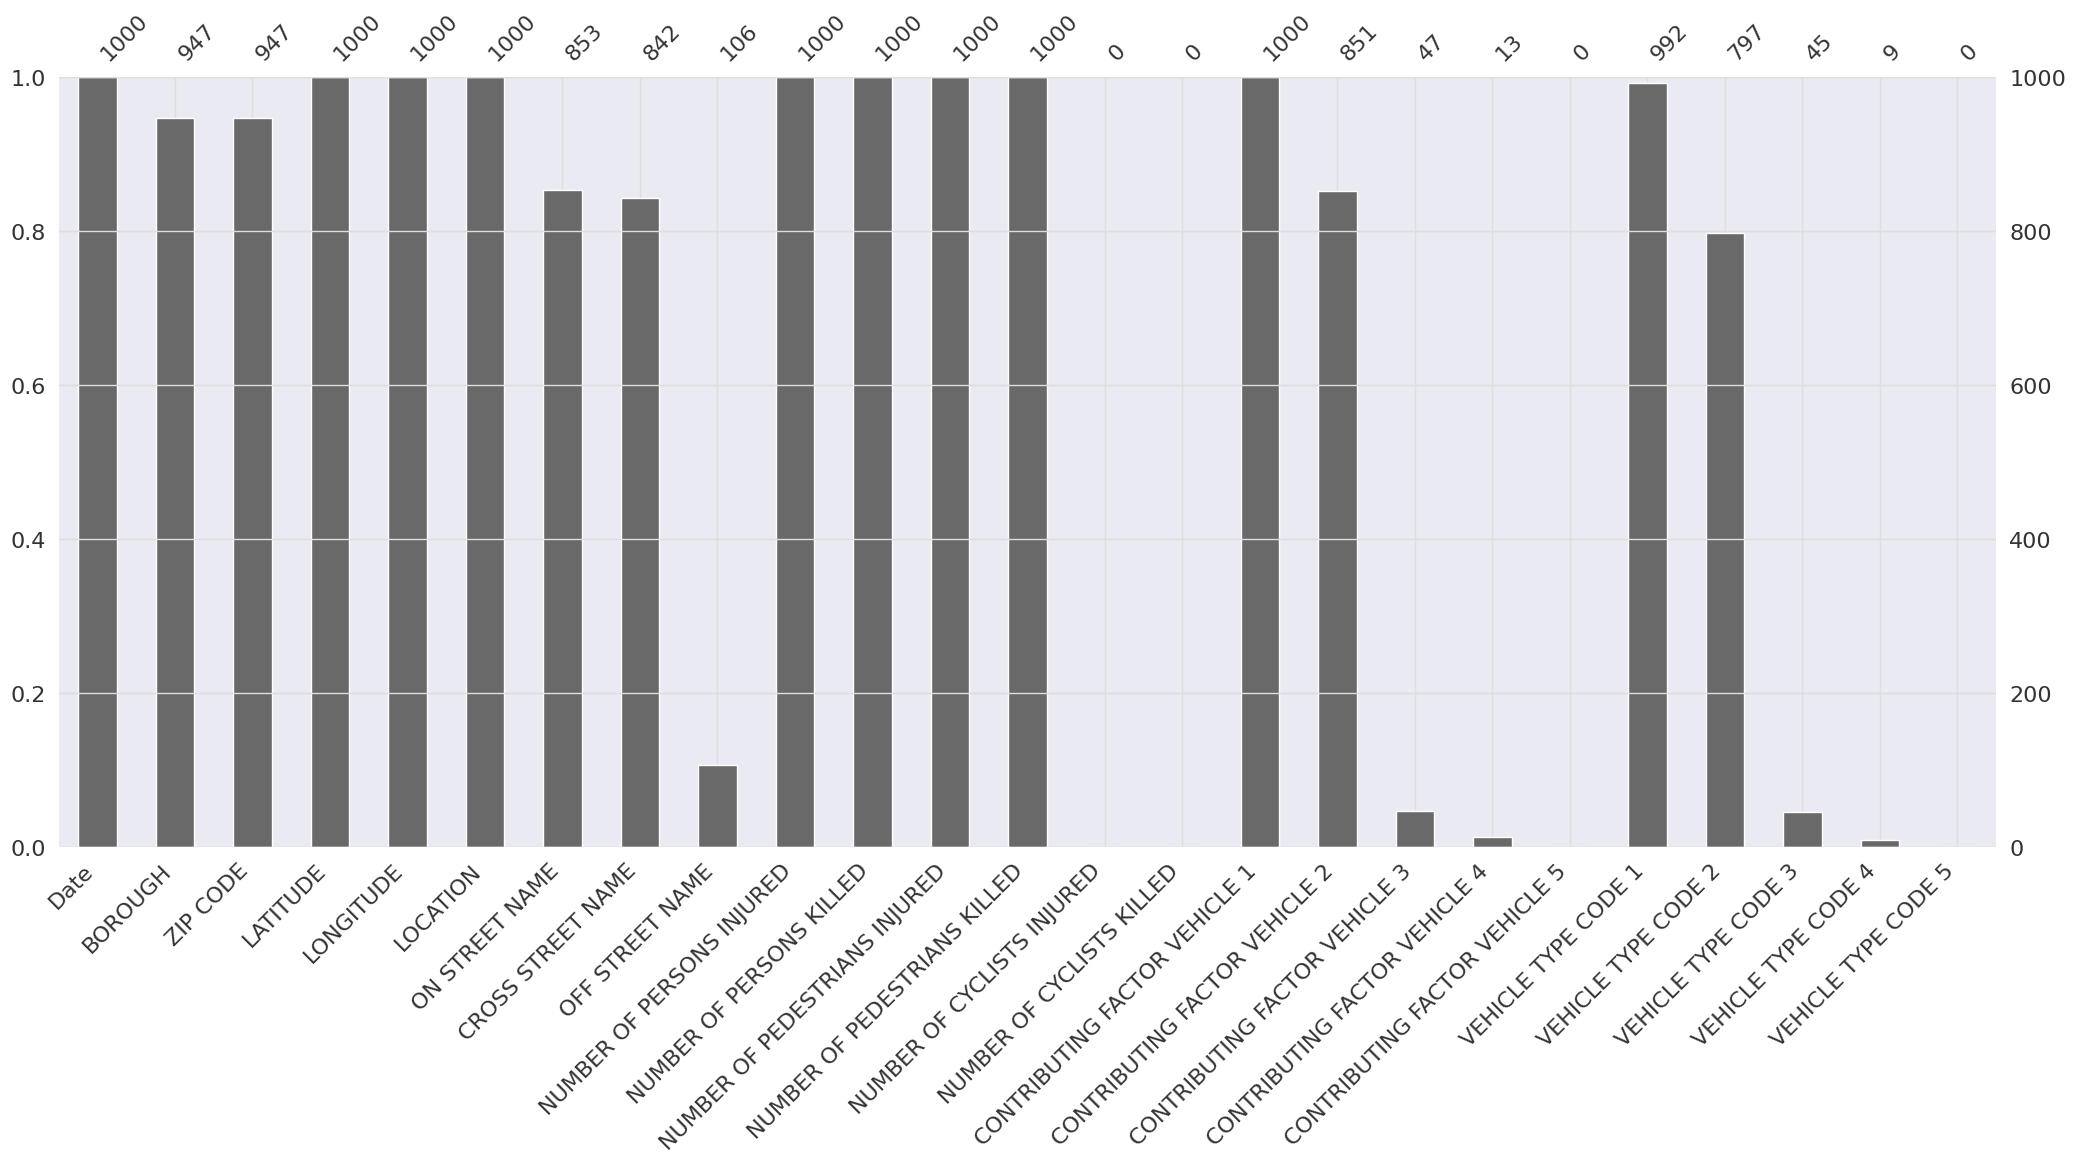

In [13]:
# Import missingno for missing data visualization
import missingno as msno
# Plot amount of missingness (visualization of nullity by column)
msno.bar(df.sample(1000))

<Axes: >

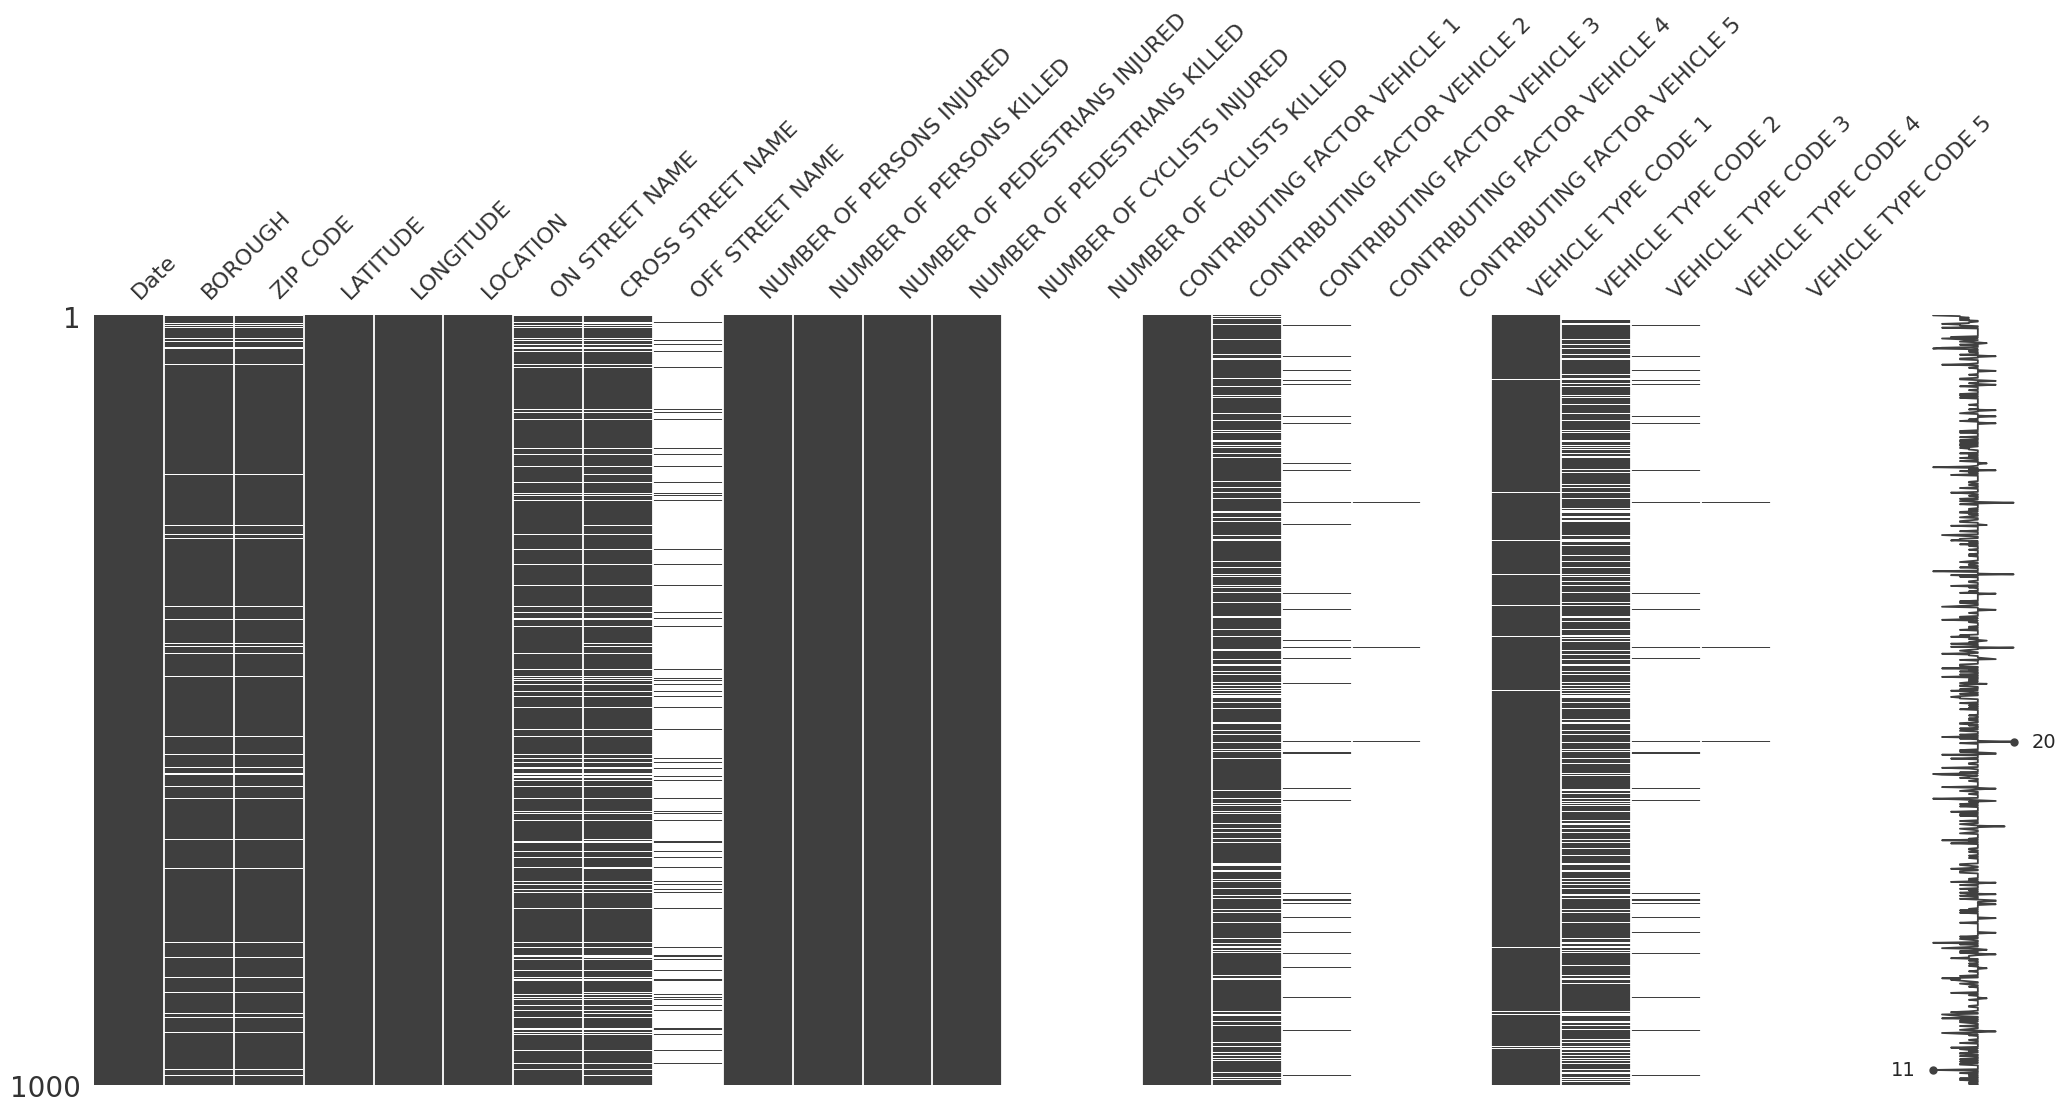

In [15]:
msno.matrix(df.sample(1000))

The sparkline on the right right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

<Axes: >

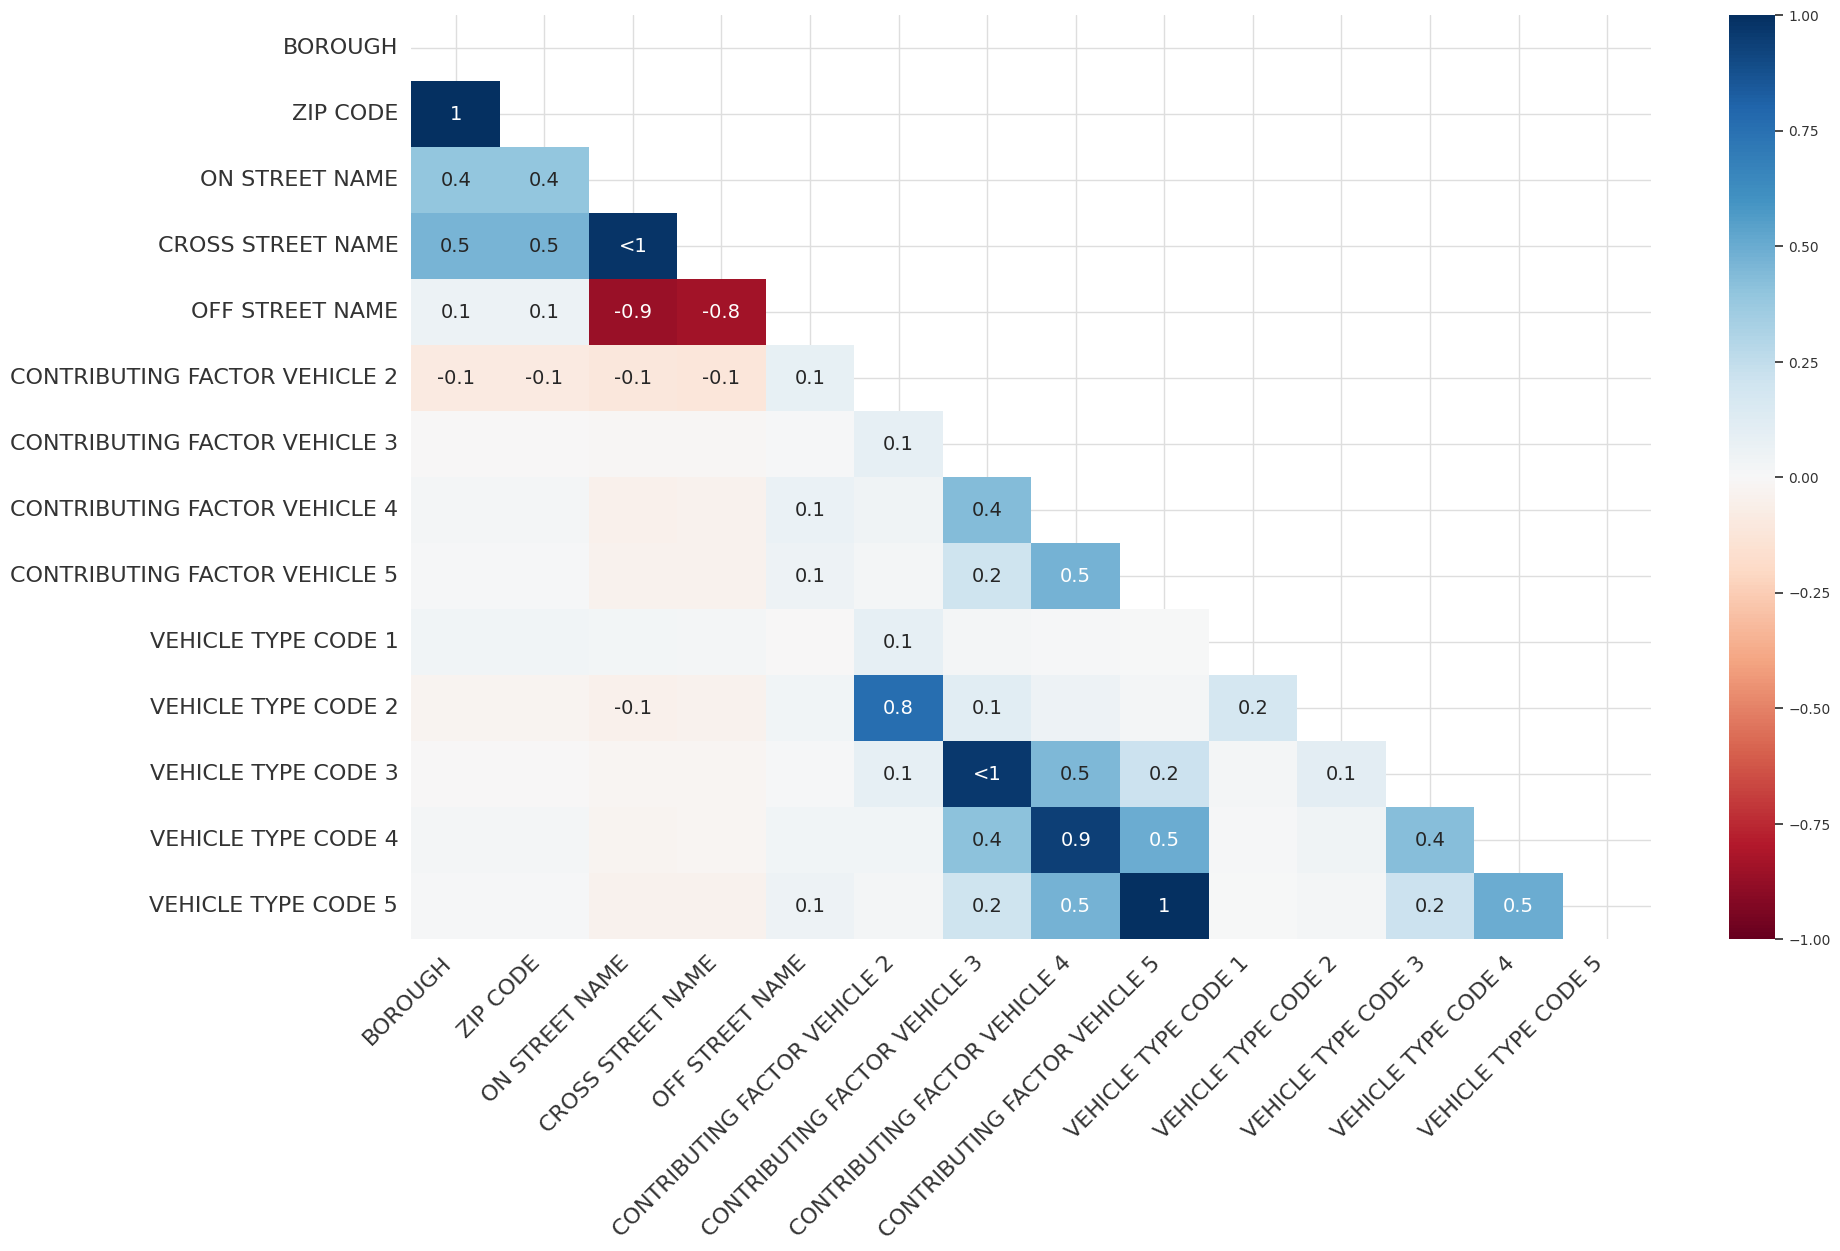

In [16]:
msno.heatmap(df.sample(1000))

**Checking for Duplicates Values**

It's also necessary to check for any duplicate entries in the dataset. The duplicate entries will cause redundency so it's better to remove duplicates from the dataset.

In [9]:
# Identify duplicate rows
duplicates = df[df.duplicated(keep=False)]

# Print the duplicate rows
if len(duplicates) > 0:
    print('Duplicate Rows:')
    print(duplicates)
else:
    print('No duplicates found.')

print("Total Duplicate Entries: ", len(duplicates))

Duplicate Rows:
                    Date    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
1351 2016-04-06 10:30:00  MANHATTAN   10014.0  40.729112 -74.010672   
1695 2016-03-14 15:00:00     QUEENS   11103.0  40.760946 -73.916293   
1696 2016-03-14 15:00:00     QUEENS   11103.0  40.760946 -73.916293   
1818 2016-03-27 10:00:00     QUEENS   11411.0  40.698018 -73.744018   
1819 2016-03-27 10:00:00     QUEENS   11411.0  40.698018 -73.744018   
3323 2016-03-23 00:05:00  MANHATTAN   10001.0  40.752723 -73.996788   
3324 2016-03-23 00:05:00  MANHATTAN   10001.0  40.752723 -73.996788   
4027 2016-02-17 08:51:00        NaN       NaN  40.703166 -73.816612   
4028 2016-02-17 08:51:00        NaN       NaN  40.703166 -73.816612   
5042 2016-04-06 10:30:00  MANHATTAN   10014.0  40.729112 -74.010672   
5636 2016-01-05 08:00:00   BROOKLYN   11206.0  40.703375 -73.937631   
5637 2016-01-05 08:00:00   BROOKLYN   11206.0  40.703375 -73.937631   
6317 2016-04-08 16:25:00     QUEENS   11379.0  40.721019 -73.

In [10]:
# Remove duplicate rows
df = df.drop_duplicates()

In [ ]:
#for col in cat_columns:
#    df[col] = df[col].astype('category')

#df.dtypes

<Axes: >

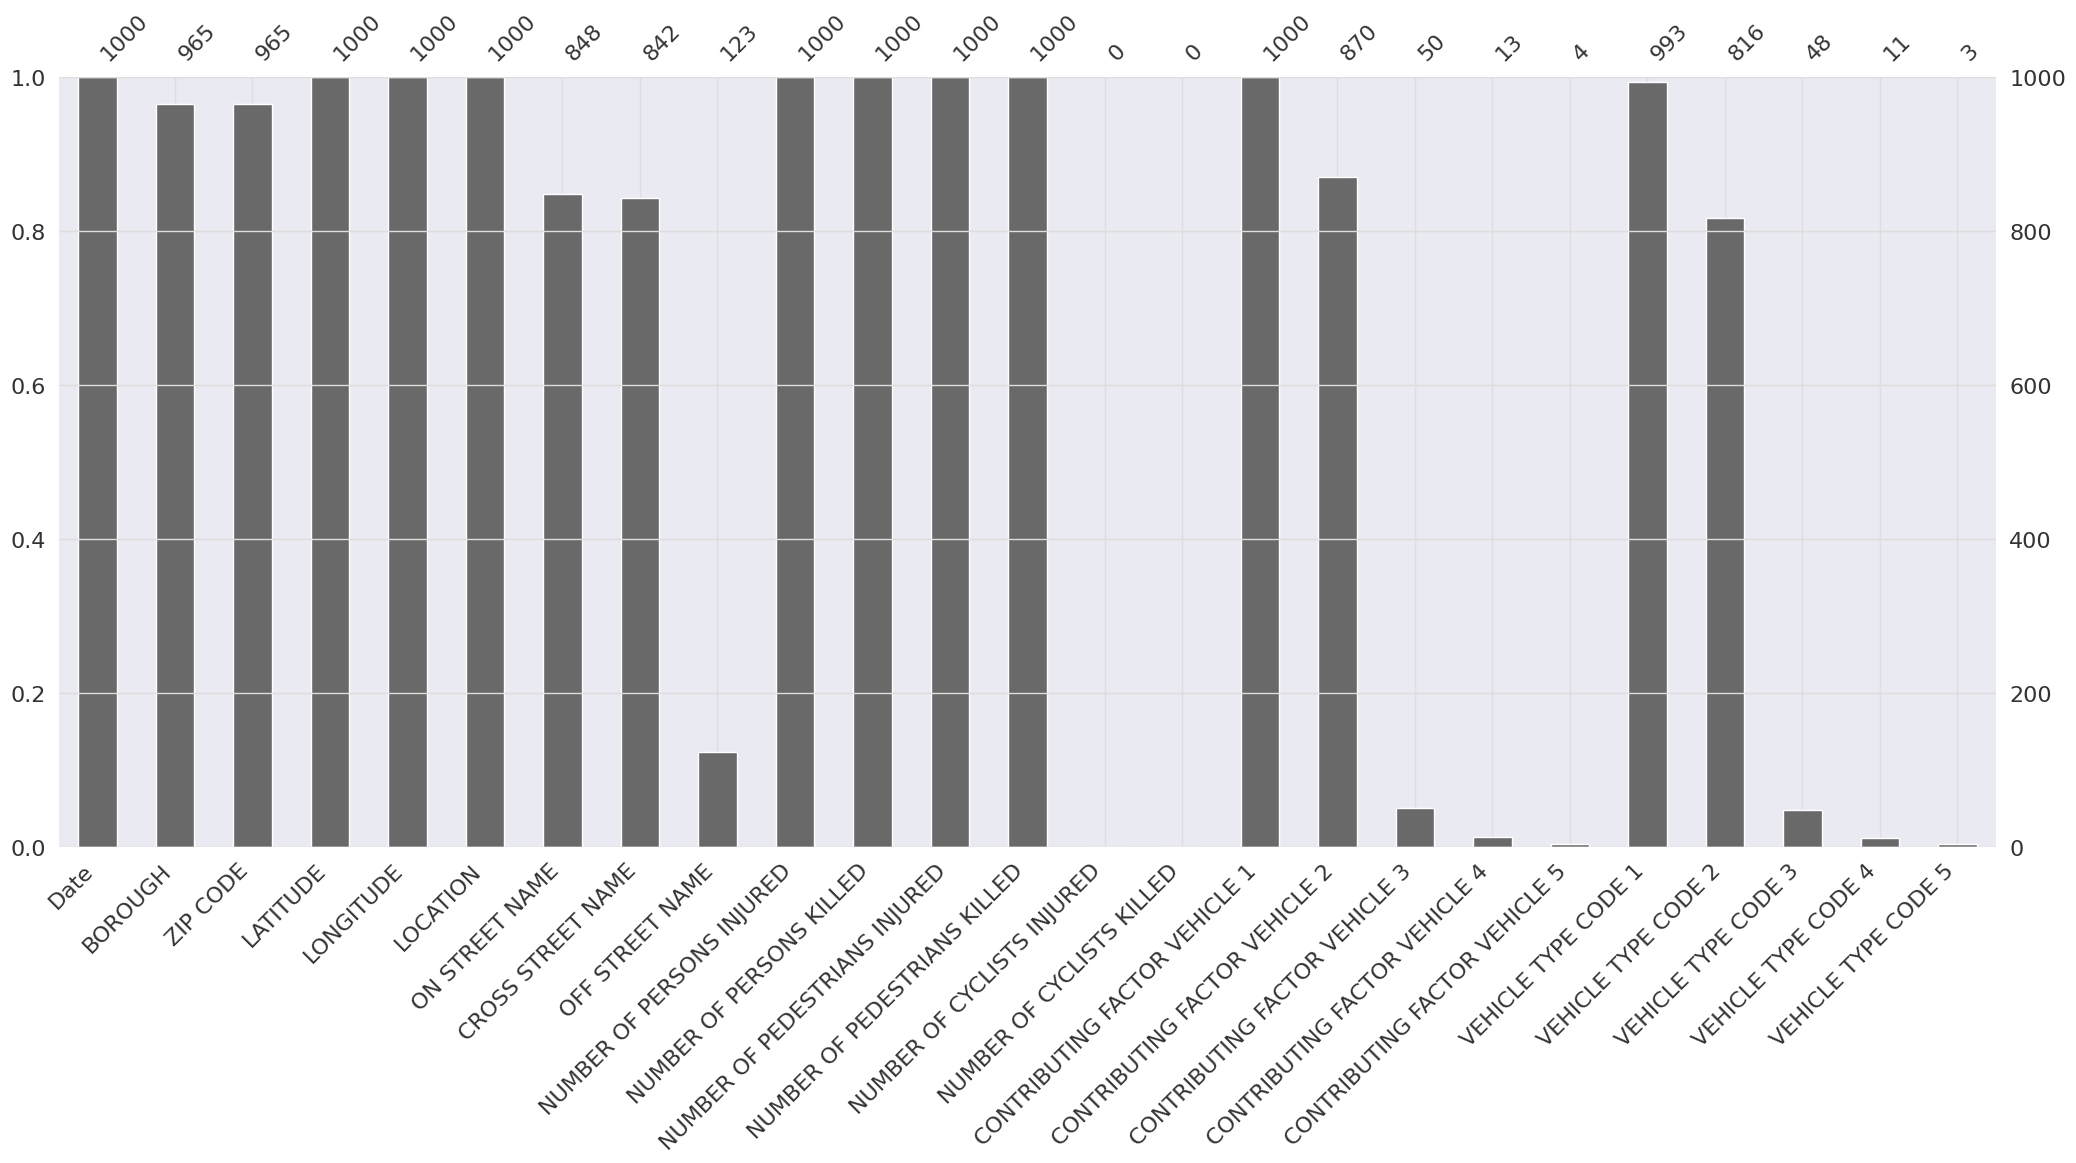

In [ ]:
msno.bar(df.sample(1000))

<Axes: >

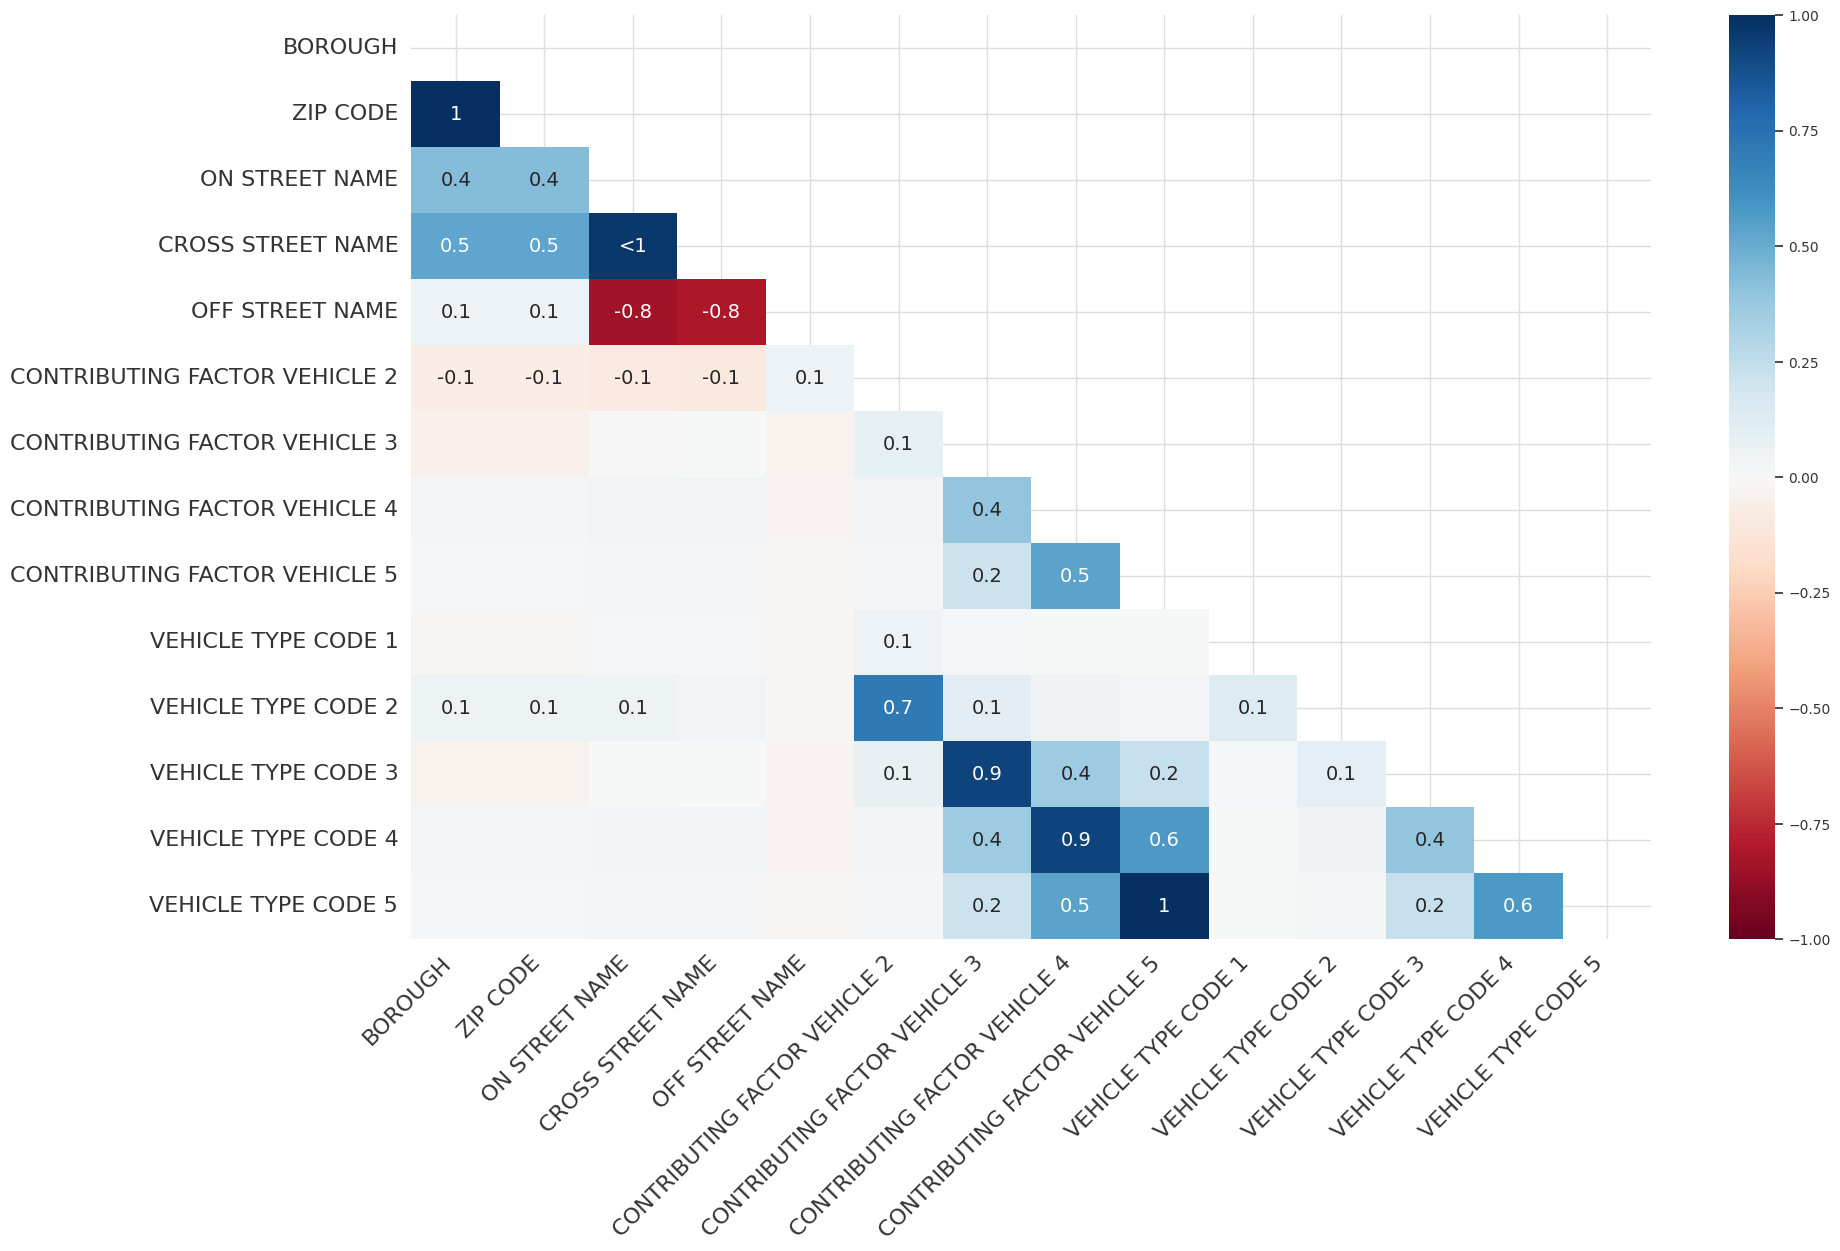

In [ ]:
msno.heatmap(df.sample(1000))

**Simple Imputation**

strategy = {‘mean’, ‘median’, ‘most_frequent’, ‘constant’}, default=’mean’

The imputation strategy.

If “mean”, then replace missing values using the mean along each column. Can only be used with numeric data.

If “median”, then replace missing values using the median along each column. Can only be used with numeric data.

If “most_frequent”, then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.

If “constant”, then replace missing values with fill_value. Can be used with strings or numeric data.

In [19]:
print('Categorical features:', cat_columns)

Categorical features: ['BOROUGH', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']


In [11]:
from sklearn.impute import SimpleImputer

# Selecting some categorical features
cat_features = ['ON STREET NAME', 'OFF STREET NAME']

# Simple Imputation: {‘mean’, ‘median’, ‘most_frequent’, ‘constant’}, default=’mean’
sim_imputer = SimpleImputer(strategy='most_frequent')
sim_imputed = sim_imputer.fit_transform(df[cat_features])
df_sim_imputed = pd.DataFrame(sim_imputed, columns=cat_features)

df_simple_joint = pd.concat([df[cat_features], df_sim_imputed], axis=1, join='inner')
df_simple_joint[25:45]

,ON STREET NAME,OFF STREET NAME,ON STREET NAME,OFF STREET NAME
25,5 AVENUE,NaN,5 AVENUE,141-40 NORTHERN BOULEVARD
26,72 STREET,NaN,72 STREET,141-40 NORTHERN BOULEVARD
27,NaN,961 EAST 174 STREET,BROADWAY,961 EAST 174 STREET
28,EMPIRE BOULEVARD,NaN,EMPIRE BOULEVARD,141-40 NORTHERN BOULEVARD
29,130 AVENUE,NaN,130 AVENUE,141-40 NORTHERN BOULEVARD
30,149 STREET,NaN,149 STREET,141-40 NORTHERN BOULEVARD
31,UTOPIA PARKWAY,NaN,UTOPIA PARKWAY,141-40 NORTHERN BOULEVARD
32,48 AVENUE,NaN,48 AVENUE,141-40 NORTHERN BOULEVARD
33,FLATBUSH AVENUE,NaN,FLATBUSH AVENUE,141-40 NORTHERN BOULEVARD
34,65 PLACE,NaN,65 PLACE,141-40 NORTHERN BOULEVARD


# **Encoding Categorical Variables**


**LabelEncoder** is a class from the scikit-learn library (sklearn.preprocessing module).
It is designed to encode target labels with values between 0 and (n_classes - 1), where n_classes is the number of unique labels in the target variable.
It is typically used for encoding target labels in classification tasks.
It doesn't handle unseen labels at the time of transformation.
It's a simple and efficient way to transform target labels into numerical form, suitable for algorithms that require numerical input.
OrdinalEncoder:

**OrdinalEncoder** is also a class from the scikit-learn library (sklearn.preprocessing module).
It is designed to encode categorical features into integer values between 0 and (n_categories - 1), where n_categories is the number of unique categories in each feature.
It's suitable for encoding features with a natural order or hierarchy, such as ordinal variables (e.g., low, medium, high).
It handles unseen categories gracefully, assigning a new category to unseen labels during transformation.
It's commonly used for preprocessing input features in machine learning models, especially when dealing with categorical variables in numerical models.

In [12]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame for encoded values
lbe_encoded = df_sim_imputed.copy()
# Apply label encoding to imputed data
lbe_encoded = df_sim_imputed.apply(LabelEncoder().fit_transform)
df_encoded_joint = pd.concat([df_sim_imputed, lbe_encoded], axis=1, join='inner')
df_encoded_joint.head(10)

,ON STREET NAME,OFF STREET NAME,ON STREET NAME,OFF STREET NAME
0,WORTMAN AVENUE,141-40 NORTHERN BOULEVARD,1661,148
1,HUBERT STREET,141-40 NORTHERN BOULEVARD,997,148
2,HENRY STREET,141-40 NORTHERN BOULEVARD,968,148
3,BROADWAY,67-64 FLEET STREET,514,637
4,BEDFORD AVENUE,141-40 NORTHERN BOULEVARD,474,148
5,COLUMBUS AVENUE,141-40 NORTHERN BOULEVARD,581,148
6,BROADWAY,6253 BROADWAY,514,613
7,ROCKAWAY BOULEVARD,141-40 NORTHERN BOULEVARD,1297,148
8,GRAND AVENUE,141-40 NORTHERN BOULEVARD,928,148
9,114 ROAD,141-40 NORTHERN BOULEVARD,28,148


**Ordinal Encoding**

In [13]:
from sklearn.preprocessing import OrdinalEncoder

# Apply ordinal encoder
ore = OrdinalEncoder()
ore_encoded = ore.fit_transform(df_sim_imputed)
ore_encoded = pd.DataFrame(ore_encoded, columns=df_sim_imputed.columns)

df_encoded_joint = pd.concat([df_sim_imputed, ore_encoded], axis=1, join='inner')
df_encoded_joint.head(10)

,ON STREET NAME,OFF STREET NAME,ON STREET NAME,OFF STREET NAME
0,WORTMAN AVENUE,141-40 NORTHERN BOULEVARD,1661.0,148.0
1,HUBERT STREET,141-40 NORTHERN BOULEVARD,997.0,148.0
2,HENRY STREET,141-40 NORTHERN BOULEVARD,968.0,148.0
3,BROADWAY,67-64 FLEET STREET,514.0,637.0
4,BEDFORD AVENUE,141-40 NORTHERN BOULEVARD,474.0,148.0
5,COLUMBUS AVENUE,141-40 NORTHERN BOULEVARD,581.0,148.0
6,BROADWAY,6253 BROADWAY,514.0,613.0
7,ROCKAWAY BOULEVARD,141-40 NORTHERN BOULEVARD,1297.0,148.0
8,GRAND AVENUE,141-40 NORTHERN BOULEVARD,928.0,148.0
9,114 ROAD,141-40 NORTHERN BOULEVARD,28.0,148.0


# **Feature Engineering**

In [14]:
!pip install category_encoders

**OneHotEncoder** Identify Unique Categories: First, identify all the unique categories present in the categorical variable. Assign Binary Vectors: For each unique category, create a binary vector with the same length as the number of unique categories. Set the element corresponding to the category to 1, and all other elements to 0. Encode Data: Replace each categorical value with its corresponding binary vector.

In [15]:
import category_encoders as ce

ohe = ce.OneHotEncoder(cols=cat_features)
df_ohe = ohe.fit_transform(df_sim_imputed)
df_ohe.head(10)

,ON STREET NAME_1,ON STREET NAME_2,ON STREET NAME_3,ON STREET NAME_4,ON STREET NAME_5,ON STREET NAME_6,ON STREET NAME_7,ON STREET NAME_8,ON STREET NAME_9,ON STREET NAME_10,...,OFF STREET NAME_748,OFF STREET NAME_749,OFF STREET NAME_750,OFF STREET NAME_751,OFF STREET NAME_752,OFF STREET NAME_753,OFF STREET NAME_754,OFF STREET NAME_755,OFF STREET NAME_756,OFF STREET NAME_757
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [1]:
!pip install feature_engine

In [16]:
from feature_engine.encoding import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(df_sim_imputed)
ohe.transform(df_sim_imputed)

,ON STREET NAME_WORTMAN AVENUE,ON STREET NAME_HUBERT STREET,ON STREET NAME_HENRY STREET,ON STREET NAME_BROADWAY,ON STREET NAME_BEDFORD AVENUE,ON STREET NAME_COLUMBUS AVENUE,ON STREET NAME_ROCKAWAY BOULEVARD,ON STREET NAME_GRAND AVENUE,ON STREET NAME_114 ROAD,ON STREET NAME_RICHMOND AVENUE,...,OFF STREET NAME_538 WEST 48 STREET,OFF STREET NAME_105-02 ROCKAWAY BOULEVARD,OFF STREET NAME_20-57 47 STREET,OFF STREET NAME_625 WEST 133 STREET,OFF STREET NAME_458 ASHFORD STREET,OFF STREET NAME_93-35 LAMONT AVENUE,OFF STREET NAME_1111 AMSTERDAM AVENUE,OFF STREET NAME_61-35 JUNCTION BOULEVARD,OFF STREET NAME_PARKING LOT 137-61 NORTHERN BLVD,OFF STREET NAME_PARKING LOT 98-01 LIBERTY AVENUE
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from feature_engine.encoding import OrdinalEncoder

od = OrdinalEncoder(encoding_method='arbitrary')
od.fit(df_sim_imputed)
od.transform(df_sim_imputed)

,ON STREET NAME,OFF STREET NAME
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
7291,679,0
7292,421,0
7293,1229,0
7294,1142,0


In [20]:
from feature_engine.encoding import CountFrequencyEncoder

cf = CountFrequencyEncoder(encoding_method='count')
cf.fit(df_sim_imputed)
cf.transform(df_sim_imputed)

,ON STREET NAME,OFF STREET NAME
0,6,6538
1,3,6538
2,1,6538
3,1151,1
4,28,6538
...,...,...
7291,3,6538
7292,29,6538
7293,3,6538
7294,3,6538


In [21]:
from feature_engine.encoding import CountFrequencyEncoder

cf = CountFrequencyEncoder(encoding_method='frequency')
cf.fit(df_sim_imputed)
cf.transform(df_sim_imputed)

,ON STREET NAME,OFF STREET NAME
0,0.000822,0.896107
1,0.000411,0.896107
2,0.000137,0.896107
3,0.157758,0.000137
4,0.003838,0.896107
...,...,...
7291,0.000411,0.896107
7292,0.003975,0.896107
7293,0.000411,0.896107
7294,0.000411,0.896107


In [22]:
from feature_engine.encoding import StringSimilarityEncoder

sse = StringSimilarityEncoder()
sse.fit(df_sim_imputed)
sse.transform(df_sim_imputed)

,ON STREET NAME_BROADWAY,ON STREET NAME_NORTHERN BOULEVARD,ON STREET NAME_ATLANTIC AVENUE,ON STREET NAME_3 AVENUE,ON STREET NAME_LINDEN BOULEVARD,ON STREET NAME_5 AVENUE,ON STREET NAME_7 AVENUE,ON STREET NAME_10 AVENUE,ON STREET NAME_11 AVENUE,ON STREET NAME_MAIN STREET,...,OFF STREET NAME_690 METROPOLITAN AVENUE,OFF STREET NAME_87-22 114 STREET,OFF STREET NAME_481 KNICKERBOCKER AVENUE,OFF STREET NAME_1711 CHURCH AVENUE,OFF STREET NAME_1402 AVENUE J,OFF STREET NAME_145 EAST 23 STREET,OFF STREET NAME_207 WEST 36 STREET,OFF STREET NAME_2100 BARTOW AVENUE,OFF STREET NAME_1 WILLIAMSBURG BRIDGE,OFF STREET NAME_PARKING LOT 98-01 LIBERTY AVENUE
0,0.454545,0.687500,0.689655,0.636364,0.666667,0.636364,0.636364,0.608696,0.608696,0.640000,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579
1,0.190476,0.580645,0.428571,0.380952,0.413793,0.380952,0.380952,0.363636,0.363636,0.583333,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579
2,0.200000,0.533333,0.444444,0.400000,0.357143,0.400000,0.400000,0.380952,0.380952,0.695652,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579
3,1.000000,0.384615,0.173913,0.125000,0.416667,0.125000,0.125000,0.117647,0.117647,0.210526,...,0.425532,0.578947,0.333333,0.333333,0.322581,0.611111,0.666667,0.333333,0.307692,0.400000
4,0.454545,0.687500,0.482759,0.636364,0.800000,0.636364,0.636364,0.608696,0.608696,0.480000,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,0.181818,0.375000,0.413793,0.363636,0.333333,0.363636,0.363636,0.434783,0.521739,0.640000,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579
7292,0.125000,0.538462,0.608696,0.875000,0.583333,0.875000,0.875000,0.823529,0.823529,0.526316,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579
7293,0.434783,0.848485,0.466667,0.521739,0.709677,0.521739,0.521739,0.500000,0.500000,0.461538,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579
7294,0.181818,0.312500,0.344828,0.363636,0.266667,0.272727,0.272727,0.260870,0.260870,0.560000,...,0.555556,0.444444,0.545455,0.558140,0.578947,0.418605,0.325581,0.651163,0.478261,0.631579


**Find the names of all the variables in the dataframe. It has the option to exlcude variables that can be parsed as datetime.**

In [53]:
from feature_engine.variable_handling import find_all_variables

vars_all = find_all_variables(df)
vars_all

['Date',
 'BOROUGH',
 'ZIP CODE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'ON STREET NAME',
 'CROSS STREET NAME',
 'OFF STREET NAME',
 'NUMBER OF PERSONS INJURED',
 'NUMBER OF PERSONS KILLED',
 'NUMBER OF PEDESTRIANS INJURED',
 'NUMBER OF PEDESTRIANS KILLED',
 'NUMBER OF CYCLISTS INJURED',
 'NUMBER OF CYCLISTS KILLED',
 'CONTRIBUTING FACTOR VEHICLE 1',
 'CONTRIBUTING FACTOR VEHICLE 2',
 'CONTRIBUTING FACTOR VEHICLE 3',
 'CONTRIBUTING FACTOR VEHICLE 4',
 'CONTRIBUTING FACTOR VEHICLE 5',
 'VEHICLE TYPE CODE 1',
 'VEHICLE TYPE CODE 2',
 'VEHICLE TYPE CODE 3',
 'VEHICLE TYPE CODE 4',
 'VEHICLE TYPE CODE 5']

**Find the names of the variables that are or can be parsed as datetime.**

In [64]:
from feature_engine.variable_handling import find_datetime_variables

var_date = find_datetime_variables(df)
var_date

['Date']

**Find the names of all the numerical and categorical variables in a dataframe**

In [63]:
from feature_engine.variable_handling import find_categorical_and_numerical_variables

cat_columns, num_columns = find_categorical_and_numerical_variables(df)
cat_columns, num_columns

(['BOROUGH',
  'LOCATION',
  'ON STREET NAME',
  'CROSS STREET NAME',
  'OFF STREET NAME',
  'CONTRIBUTING FACTOR VEHICLE 1',
  'CONTRIBUTING FACTOR VEHICLE 2',
  'CONTRIBUTING FACTOR VEHICLE 3',
  'CONTRIBUTING FACTOR VEHICLE 4',
  'CONTRIBUTING FACTOR VEHICLE 5',
  'VEHICLE TYPE CODE 1',
  'VEHICLE TYPE CODE 2',
  'VEHICLE TYPE CODE 3',
  'VEHICLE TYPE CODE 4',
  'VEHICLE TYPE CODE 5'],
 ['ZIP CODE',
  'LATITUDE',
  'LONGITUDE',
  'NUMBER OF PERSONS INJURED',
  'NUMBER OF PERSONS KILLED',
  'NUMBER OF PEDESTRIANS INJURED',
  'NUMBER OF PEDESTRIANS KILLED',
  'NUMBER OF CYCLISTS INJURED',
  'NUMBER OF CYCLISTS KILLED'])

**Example: How to drop correlated variables**

In [30]:
X = pd.DataFrame(dict(x1 = [1,2,1,1], x2 = [2,4,3,1], x3 = [1, 0, 0, 1]))
X.corr()

,x1,x2,x3
x1,1.000000,0.774597,-0.577350
x2,0.774597,1.000000,-0.894427
x3,-0.577350,-0.894427,1.000000


In [48]:
from feature_engine.selection import DropCorrelatedFeatures

#drop variables with correlation above 0.7
dcf = DropCorrelatedFeatures(threshold=0.7)
dc = dcf.fit_transform(X)
dc

,x1,x3
0,1,1
1,2,0
2,1,0
3,1,1


In [50]:
X_dc_joint = pd.concat([X, dc], axis=1, join='inner')
X_dc_joint

,x1,x2,x3,x1,x3
0,1,2,1,1,1
1,2,4,0,2,0
2,1,3,0,1,0
3,1,1,1,1,1
